# Simulate balanced tree

In [1]:
from platform import python_version
print(python_version())

3.8.5


In [ ]:
# check number of cores
! nproc

In [2]:
from pathlib import Path
import toytree
import toyplot, toyplot.svg
import numpy as np
import pandas as pd
import itertools
import ipcoal
from concurrent.futures import ProcessPoolExecutor

In [3]:
# make directory for saving figures
#Path("./nb6_output/").mkdir(exist_ok=True)

## (A-B) BALANCED TREE SETUP

In [4]:
# get an ultrametric balanced tree
BALTREE = toytree.rtree.baltree(8, treeheight=1e6)
EDGES1 = [2,3,9,6,7,12]
EDGES2 = [2,3,9,10,6,7,12,13]
NE_DEFAULT = 5e5
GT_DEFAULT = 1
RNG = np.random.default_rng(123)
NLOCI = 10_000

### 1. No modifications on root edges = use EDGES1

### 1.1 Species tree with variable `Ne`

In [5]:
# set parameters on the species tree
baltree_1_ne = BALTREE.copy()
baltree_1_ne = baltree_1_ne.set_node_data("Ne", {i: NE_DEFAULT * 20 for i in EDGES1}, default=NE_DEFAULT)
baltree_1_ne = baltree_1_ne.set_node_data("gt", default=GT_DEFAULT)
baltree_1_ne = baltree_1_ne.set_node_data("tg", {i: i.dist / i.gt for i in baltree_1_ne})
baltree_1_ne = baltree_1_ne.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in baltree_1_ne})
baltree_1_ne = baltree_1_ne.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in baltree_1_ne})
baltree_1_ne = baltree_1_ne.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in baltree_1_ne})
baltree_1_ne = baltree_1_ne.set_node_data("tg_rho", {i: i.tg * i.rho for i in baltree_1_ne})
baltree_1_ne = baltree_1_ne.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in baltree_1_ne})

# convert edge lens to units of generations.
baltree_1_ne = baltree_1_ne.set_node_data("dist", {i: i.tg for i in baltree_1_ne})

# show data
baltree_1_ne.get_node_data()

,idx,name,height,dist,support,Ne,gt,rho,tc,tg,tg_rho,tg_theta,theta
0,0,r0,0.000000,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,0.000007,0.02
1,1,r1,0.000000,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,0.000007,0.02
2,2,r2,0.000000,333333.333333,NaN,10000000.0,1,0.040,0.016667,333333.333333,13333.333333,0.000133,0.40
3,3,r3,0.000000,333333.333333,NaN,10000000.0,1,0.040,0.016667,333333.333333,13333.333333,0.000133,0.40
4,4,r4,0.000000,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,0.000007,0.02
5,5,r5,0.000000,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,0.000007,0.02
6,6,r6,0.000000,333333.333333,NaN,10000000.0,1,0.040,0.016667,333333.333333,13333.333333,0.000133,0.40
7,7,r7,0.000000,333333.333333,NaN,10000000.0,1,0.040,0.016667,333333.333333,13333.333333,0.000133,0.40
8,8,,333333.333333,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,0.000007,0.02
9,9,,333333.333333,333333.333333,NaN,10000000.0,1,0.040,0.016667,333333.333333,13333.333333,0.000133,0.40


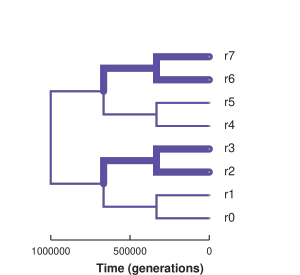

In [7]:
# draw tree figure and save it
# kwargs settings for tree drawing
kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 7), edge_colors="gt",
)

# canvas for tree
c, a, m = baltree_1_ne.ladderize().draw(**kwargs)
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./nb6_output/tree-bal-ne-gunits.svg")
c


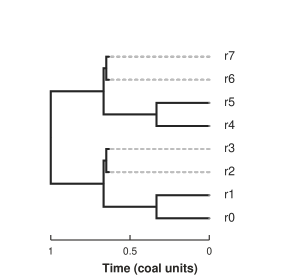

In [9]:
# draw tree w/ edge lengths in coal units
kwargs = dict(scale_bar=True, tip_labels_align=True)
c, a, m = baltree_1_ne.set_node_data("dist", {i: i.tc for i in baltree_1_ne}).ladderize().draw(**kwargs);
a.x.label.text = "Time (coal units)"
toyplot.svg.render(c, "./nb6_output/tree-bal-ne-cunits.svg")
c

### 1.2 Species tree with variable `gt`

In [10]:
baltree_1_gt = BALTREE.copy()
baltree_1_gt = baltree_1_gt.set_node_data("Ne", default=NE_DEFAULT)
baltree_1_gt = baltree_1_gt.set_node_data("gt", {i: GT_DEFAULT * 20 for i in EDGES1}, default=GT_DEFAULT)
baltree_1_gt = baltree_1_gt.set_node_data("tg", {i: i.dist / i.gt for i in baltree_1_gt})
baltree_1_gt = baltree_1_gt.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in baltree_1_gt})
baltree_1_gt = baltree_1_gt.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in baltree_1_gt})
baltree_1_gt = baltree_1_gt.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in baltree_1_gt})
baltree_1_gt = baltree_1_gt.set_node_data("tg_rho", {i: i.tg * i.rho for i in baltree_1_gt})
baltree_1_gt = baltree_1_gt.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in baltree_1_gt})

# convert dist to units of generations. Draw and show data
baltree_1_gt = baltree_1_gt.set_node_data("dist", {i: i.tg for i in baltree_1_gt})
baltree_1_gt.get_node_data()

,idx,name,height,dist,support,Ne,gt,rho,tc,tg,tg_rho,tg_theta,theta
0,0,r0,0.000000,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,6.666667e-06,0.02
1,1,r1,0.000000,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,6.666667e-06,0.02
2,2,r2,633333.333333,16666.666667,NaN,500000.0,20,0.002,0.016667,16666.666667,33.333333,3.333333e-07,0.02
3,3,r3,633333.333333,16666.666667,NaN,500000.0,20,0.002,0.016667,16666.666667,33.333333,3.333333e-07,0.02
4,4,r4,0.000000,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,6.666667e-06,0.02
5,5,r5,0.000000,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,6.666667e-06,0.02
6,6,r6,633333.333333,16666.666667,NaN,500000.0,20,0.002,0.016667,16666.666667,33.333333,3.333333e-07,0.02
7,7,r7,633333.333333,16666.666667,NaN,500000.0,20,0.002,0.016667,16666.666667,33.333333,3.333333e-07,0.02
8,8,,333333.333333,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,6.666667e-06,0.02
9,9,,650000.000000,16666.666667,NaN,500000.0,20,0.002,0.016667,16666.666667,33.333333,3.333333e-07,0.02


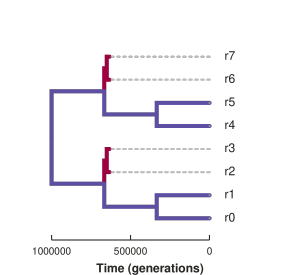

In [12]:
# draw tree figure and save it
kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 4), edge_colors="gt",
)
c, a, m = baltree_1_gt.ladderize().draw(**kwargs);
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./nb6_output/tree-bal-gt-gunits.svg")
c

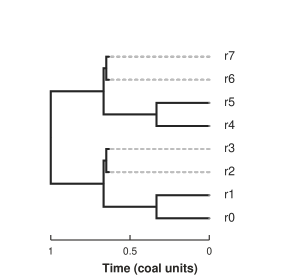

In [14]:
# draw tree w/ edge lengths in coal units
kwargs = dict(scale_bar=True, tip_labels_align=True)
c, a, m = baltree_1_gt.set_node_data("dist", {i: i.tc for i in baltree_1_gt}).ladderize().draw(**kwargs);
a.x.label.text = "Time (coal units)"
toyplot.svg.render(c, "./nb6_output/tree-bal-gt-cunits.svg")
c

### 2. Modifications on root edges = use EDGES2

### 2.1 Species tree with variable `Ne`

In [39]:
# set parameters on the species tree
baltree_2_ne = BALTREE.copy()
# set root node dist value (node 14)
baltree_2_ne.set_node_data("dist", {14: 1e6/3}, inplace=True);

baltree_2_ne = baltree_2_ne.set_node_data("Ne", {i: NE_DEFAULT * 20 for i in EDGES2}, default=NE_DEFAULT)
baltree_2_ne = baltree_2_ne.set_node_data("gt", default=GT_DEFAULT)
baltree_2_ne = baltree_2_ne.set_node_data("tg", {i: i.dist / i.gt for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("tg_rho", {i: i.tg * i.rho for i in baltree_2_ne})
baltree_2_ne = baltree_2_ne.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in baltree_2_ne})

# convert edge lens to units of generations.
baltree_2_ne = baltree_2_ne.set_node_data("dist", {i: i.tg for i in baltree_2_ne})

# show data
baltree_2_ne.get_node_data()

,idx,name,height,dist,support,Ne,gt,rho,tc,tg,tg_rho,tg_theta,theta
0,0,r0,0.000000,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,0.000007,0.02
1,1,r1,0.000000,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,0.000007,0.02
2,2,r2,0.000000,333333.333333,NaN,10000000.0,1,0.040,0.016667,333333.333333,13333.333333,0.000133,0.40
3,3,r3,0.000000,333333.333333,NaN,10000000.0,1,0.040,0.016667,333333.333333,13333.333333,0.000133,0.40
4,4,r4,0.000000,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,0.000007,0.02
5,5,r5,0.000000,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,0.000007,0.02
6,6,r6,0.000000,333333.333333,NaN,10000000.0,1,0.040,0.016667,333333.333333,13333.333333,0.000133,0.40
7,7,r7,0.000000,333333.333333,NaN,10000000.0,1,0.040,0.016667,333333.333333,13333.333333,0.000133,0.40
8,8,,333333.333333,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,0.000007,0.02
9,9,,333333.333333,333333.333333,NaN,10000000.0,1,0.040,0.016667,333333.333333,13333.333333,0.000133,0.40


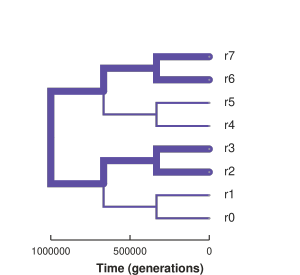

In [40]:
# draw tree figure and save it
# kwargs settings for tree drawing
kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 7), edge_colors="gt",
)

# canvas for tree
c, a, m = baltree_2_ne.ladderize().draw(**kwargs)
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./nb6_output/tree2-bal-ne-gunits.svg")
c


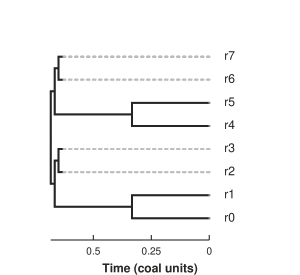

In [41]:
# draw tree w/ edge lengths in coal units
kwargs = dict(scale_bar=True, tip_labels_align=True)
c, a, m = baltree_2_ne.set_node_data("dist", {i: i.tc for i in baltree_2_ne}).ladderize().draw(**kwargs);
a.x.label.text = "Time (coal units)"
toyplot.svg.render(c, "./nb6_output/tree2-bal-ne-cunits.svg")
c

### 2.2 Species tree with variable `gt`

In [42]:
baltree_2_gt = BALTREE.copy()
# set root node dist value (node 14)
baltree_2_gt.set_node_data("dist", {14: 1e6/3}, inplace=True);

baltree_2_gt = baltree_2_gt.set_node_data("Ne", default=NE_DEFAULT)
baltree_2_gt = baltree_2_gt.set_node_data("gt", {i: GT_DEFAULT * 20 for i in EDGES2}, default=GT_DEFAULT)
baltree_2_gt = baltree_2_gt.set_node_data("tg", {i: i.dist / i.gt for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("tc", {i: i.tg / (2 * i.Ne) for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("theta", {i: 4 * i.Ne * 1e-8 for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("rho", {i: 4 * i.Ne * 1e-9 for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("tg_rho", {i: i.tg * i.rho for i in baltree_2_gt})
baltree_2_gt = baltree_2_gt.set_node_data("tg_theta", {i: i.tg * i.theta * 1e-9 for i in baltree_2_gt})

# convert dist to units of generations. Draw and show data
baltree_2_gt = baltree_2_gt.set_node_data("dist", {i: i.tg for i in baltree_2_gt})
baltree_2_gt.get_node_data()

,idx,name,height,dist,support,Ne,gt,rho,tc,tg,tg_rho,tg_theta,theta
0,0,r0,0.000000,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,6.666667e-06,0.02
1,1,r1,0.000000,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,6.666667e-06,0.02
2,2,r2,633333.333333,16666.666667,NaN,500000.0,20,0.002,0.016667,16666.666667,33.333333,3.333333e-07,0.02
3,3,r3,633333.333333,16666.666667,NaN,500000.0,20,0.002,0.016667,16666.666667,33.333333,3.333333e-07,0.02
4,4,r4,0.000000,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,6.666667e-06,0.02
5,5,r5,0.000000,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,6.666667e-06,0.02
6,6,r6,633333.333333,16666.666667,NaN,500000.0,20,0.002,0.016667,16666.666667,33.333333,3.333333e-07,0.02
7,7,r7,633333.333333,16666.666667,NaN,500000.0,20,0.002,0.016667,16666.666667,33.333333,3.333333e-07,0.02
8,8,,333333.333333,333333.333333,NaN,500000.0,1,0.002,0.333333,333333.333333,666.666667,6.666667e-06,0.02
9,9,,650000.000000,16666.666667,NaN,500000.0,20,0.002,0.016667,16666.666667,33.333333,3.333333e-07,0.02


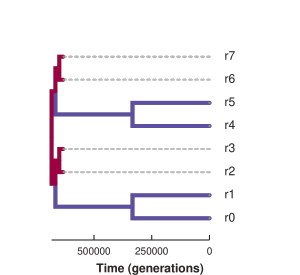

In [43]:
# draw tree figure and save it
kwargs = dict(
    scale_bar=True, tip_labels_align=True, 
    edge_widths=("Ne", 2, 4), edge_colors="gt",
)
c, a, m = baltree_2_gt.ladderize().draw(**kwargs);
a.x.label.text = "Time (generations)"
toyplot.svg.render(c, "./nb6_output/tree2-bal-gt-gunits.svg")
c

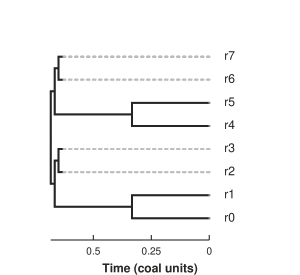

In [44]:
# draw tree w/ edge lengths in coal units
kwargs = dict(scale_bar=True, tip_labels_align=True)
c, a, m = baltree_2_gt.set_node_data("dist", {i: i.tc for i in baltree_2_gt}).ladderize().draw(**kwargs);
a.x.label.text = "Time (coal units)"
toyplot.svg.render(c, "./nb6_output/tree2-bal-gt-cunits.svg")
c

## FUNCTIONS

In [22]:
def one_batch_sim(tree, nloci, nsites, nthreads, seed, infer):
    """Return two dataframes with genealogies and gene trees, respectively."""
    model = ipcoal.Model(tree=tree, seed_trees=seed, seed_mutations=seed)
    model.sim_loci(nloci, nsites)
    if (nsites == 1) or (not infer):
        raxdf = None
    else:
        raxdf = ipcoal.phylo.infer_raxml_ng_trees(
            model, nthreads=nthreads, nproc=1, nworkers=1, do_not_autoscale_threads=True)
    return model.df, raxdf

In [23]:
def batch_sims(tree: toytree.ToyTree, nloci: int = 1000, nsites: int = 1e4, njobs: int = 10, nthreads: int = 4, infer: bool = True):    
    """Return dataframes from simulations and tree inferences distributed to run in parallel"""
    if nloci == 1:
        return one_batch_sim(tree, nloci, nsites, nthreads, None)

    # not perfect
    nloci_per = int(nloci / njobs)
    rasyncs = {}
    with ProcessPoolExecutor(max_workers=njobs) as pool:
        for i in range(njobs):
            rasyncs[i] = pool.submit(one_batch_sim, *(tree, nloci_per, nsites, nthreads, None, infer))
    gdata = []
    rdata = []
    for i in range(njobs):
        gdf, rdf = rasyncs[i].result()
        gdf.locus += i * nloci_per
        gdata.append(gdf)
        if rdf is not None:
            rdf.locus += i * nloci_per
            rdata.append(rdf)
    gdata = pd.concat(gdata, ignore_index=True)
    if rdata:
        rdata = pd.concat(rdata, ignore_index=True)
    return gdata, rdata

In [24]:
def one_concat(tree, nloci, nsites, nthreads, seed: int = None, nworkers: int = None):
    """Infer a concatenation tree"""
    model = ipcoal.Model(tree=tree, seed_trees=seed, seed_mutations=seed)
    model.sim_loci(nloci, nsites)
    raxtree = ipcoal.phylo.infer_raxml_ng_tree(
            model, nthreads=nthreads, nworkers=nworkers, do_not_autoscale_threads=True)
    return raxtree

In [25]:
def batch_concat(tree: toytree.ToyTree, nloci: int = 1000, nsites: int = 1e4, njobs: int = 10, nthreads: int = 4, nreps: int = 10):
    """Return a list of inferred concatenation trees"""
    if nloci == 1:
        return one_batch_sim(tree, nloci, nsites, nthreads, None)

    # not perfect
    rasyncs = {}
    with ProcessPoolExecutor(max_workers=njobs) as pool:
        for i in range(nreps):
            rasyncs[i] = pool.submit(one_concat, *(tree, nloci, nsites, nthreads, None))
    return [i.result() for i in rasyncs.values()]


In [26]:
def iter_first_genealogies(model_df: pd.DataFrame):
    for _, df in model_df.groupby("locus"):
        yield toytree.tree(df.iloc[0, 6])

In [27]:
def plot_matrix(
    dat: np.ndarray,
    domain_min: float = None,
    domain_max: float = None,
    cmap: str = "BlueRed",
    gap: float = 0,
    mask_diagonal: bool = False,
    color_bar: bool = False,
) -> "Canvas":
    """Return a matrix heatmap """
    
    # get min and max of the off-diagonal elements
    if mask_diagonal:
        dat = dat.copy()
        dat[np.diag_indices_from(dat)] = np.nanmean(dat)
        
    dmin = dat.min() if domain_min is None else domain_min
    dmax = dat.max() if domain_max is None else domain_max
    cmap = toyplot.color.brewer.map(cmap, domain_min=dmin, domain_max=dmax)
    
    # add 20 pixels to the right if legend
    if color_bar:
        color_bar = 20
    else:
        color_bar = 0
    
    # draw the matrix table
    canvas = toyplot.Canvas(300 + color_bar, 300)
    ax1 = canvas.table(
        rows=dat.shape[0], 
        columns=dat.shape[1],
        bounds=(50, 250, 50, 250),
    )
    
    # apply colors to cells but not diagonals
    for ridx in range(dat.shape[0]):
        for cidx in range(dat.shape[1]):
            col = cmap.color(dat[ridx, cidx])
            ax1.cells.cell[ridx, cidx].style = {'fill': col, 'stroke': 'none'}
            
            # overwrite if masking
            if (ridx == cidx) and mask_diagonal:
                ax1.cells.cell[ridx, cidx].style = {'fill': 'black', 'stroke': 'none'}
            
    # style spacing between grid cells            
    ax1.body.gaps.columns[...] = gap
    ax1.body.gaps.rows[...] = gap
    
    ax2 = canvas.cartesian(bounds=(50, 250, 50, 250), margin=0, padding=0)
    ax2.x.ticks.labels.show = False
    ax2.x.spine.style["stroke"] = "black"
    ax2.x.spine.style["stroke-width"] = 2
    ax2.y.ticks.labels.show = False
    ax2.y.spine.style["stroke"] = "black"
    ax2.y.spine.style["stroke-width"] = 2
    ax3 = ax2.share('x')
    ax3.y.ticks.labels.show = False
    ax3.y.spine.style["stroke"] = "black"
    ax3.y.spine.style["stroke-width"] = 2
    ax4 = ax2.share('y')
    ax4.x.ticks.labels.show = False
    ax4.x.spine.style["stroke"] = "black"
    ax4.x.spine.style["stroke-width"] = 2
    
    # add a colorbar to canvas
    if color_bar:
        numberline = canvas.numberline(270, 250, 270, 50)
        numberline.colormap(cmap, width=15, style={"stroke-width": 2, "stroke": "black"})
        numberline.axis.ticks.locator = toyplot.locator.Extended(only_inside=True)
        numberline.axis.ticks.show = True
        numberline.axis.ticks.near = False
        numberline.axis.ticks.style["stroke-width"] = 2
        numberline.axis.spine.style["stroke-width"] = 2
        numberline.axis.ticks.labels.style["font-size"] = 14
    return canvas

### Test batch functions

In [ ]:
# test: get dataframes of true and inferred trees
gdf, rdf = batch_sims(baltree_2_gt, nloci=100, nsites=1000, njobs=20, nthreads=3)
print(gdf.head())
print(rdf.head())

In [ ]:
# test: get raxml concat trees for (nloci * nsites) matrix
concats = batch_concat(baltree_2_gt, nloci=100, nsites=1e4, njobs=10, nthreads=3, nreps=10)
toytree.mtree(concats).draw();

## VERIFICATION

### Ensure species tree scenario is in anomaly zone
### 2.1 Variable `Ne` scenario
a) Astral inferred from true genealogies should get the tree **CORRECT**:

In [ ]:
ugdf_ne, _ = batch_sims(baltree_2_ne, nloci=NLOCI, nsites=1, njobs=20, nthreads=3, infer=False)

In [ ]:
atree_true_ne = ipcoal.phylo.infer_astral_tree(ugdf_ne.genealogy).root("r7").ladderize()

In [ ]:
c, a, m = atree_true_ne.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./nb6_output/infer-ne2-true-astral.svg")
c

b) RAxML inferred from concatenated sequences should get the tree **WRONG**:

In [ ]:
concat_tree_ne = one_concat(baltree_2_ne, nloci=NLOCI, nsites=1e3, nthreads=30, seed=0, nworkers=2)

In [ ]:
c, a, m = concat_tree_ne.root("r7").ladderize().draw(use_edge_lengths=False);
toyplot.svg.render(c, "./nb6_output/infer-ne2-1e3-concat.svg")
c

c) Astral inferred from empirical gene trees should get it increasingly wrong as locus lengths increase:

Inferred raxml trees input to astral should probably get it right when nsites is **small**


In [ ]:
_, rdf_ne_1e3 = batch_sims(baltree_2_ne, nloci=NLOCI, nsites=1e3, njobs=20, nthreads=3, infer=True)

In [ ]:
rdf_ne_1e3.to_csv("./rax-df-ne-1e3.csv")

In [ ]:
atree_1e3_ne = ipcoal.phylo.infer_astral_tree(rdf_ne_1e3.gene_tree).root("r7").ladderize()

In [ ]:
c, a, m = atree_1e3_ne.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./nb6_output/infer-ne2-1e3-astral.svg")
c

Inferred raxml trees input to astral should get it WRONG when nsites is very **large**

In [ ]:
gdf_ne_1e5, rdf_ne_1e5 = batch_sims(baltree_2_ne, nloci=NLOCI, nsites=1e5, njobs=20, nthreads=3, infer=True)

In [ ]:
rdf_ne_1e5.to_csv("./rax-df-ne-1e5.csv")

In [ ]:
atree_1e5_ne = ipcoal.phylo.infer_astral_tree(rdf_ne_1e5.gene_tree).root("r7").ladderize()

In [ ]:
c, a, m = atree_1e5_ne.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./nb6_output/infer-ne2-1e5-astral.svg")
c

Compare inferred raxml trees output small vs. large

In [ ]:
# nsites small output
hist = [j for i, j in toytree.mtree(rdf_ne_1e3.gene_tree).get_unique_topologies()]
c, a, m = toyplot.plot(np.array(hist) / sum(hist), height=250, width=350, xmin=1, xscale="log")
a.x.label.text = "topology rank"
a.y.label.text = "frequency"
toytree.utils.set_axes_ticks_external(a)
c

In [ ]:
# nsites large output
hist = [j for i, j in toytree.mtree(rdf_ne_1e5.gene_tree).get_unique_topologies()]
c, a, m = toyplot.plot(np.array(hist) / sum(hist), height=250, width=350, xmin=1, xscale="log")
a.x.label.text = "topology rank"
a.y.label.text = "frequency"
toytree.utils.set_axes_ticks_external(a)
c

### 2.2 Variable `gt` scenario

a) Astral inferred from true genealogies should get the tree **CORRECT**:

In [ ]:
ugdf_gt, _ = batch_sims(baltree_2_gt, nloci=NLOCI, nsites=1, njobs=20, nthreads=3, infer=False)

In [ ]:
atree_true_gt = ipcoal.phylo.infer_astral_tree(ugdf_gt.genealogy).root("r7").ladderize()

In [ ]:
c, a, m = atree_true_gt.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./nb6_output/infer-gt2-true-astral.svg")
c

b) RAxML inferred from concatenated sequences should get the tree **WRONG**:

In [ ]:
concat_tree_gt = one_concat(baltree_2_gt, nloci=NLOCI, nsites=1e3, nthreads=30, seed=0, nworkers=2)

In [ ]:
c, a, m = concat_tree_gt.root("r7").ladderize().draw(use_edge_lengths=False);
toyplot.svg.render(c, "./nb6_output/infer-gt2-1e7-concat.svg")
c

c) Astral inferred from empirical gene trees should get it increasingly wrong as locus lengths increase:

Inferred raxml trees input to astral should probably get it right when nsites is **small**

In [ ]:
gdf_gt_1e3, rdf_gt_1e3 = batch_sims(baltree_2_gt, nloci=NLOCI, nsites=1e3, njobs=20, nthreads=3, infer=True)

In [ ]:
rdf_gt_1e3.to_csv("./rax-df-gt-1e3.csv")

In [ ]:
atree_1e3_gt = ipcoal.phylo.infer_astral_tree(rdf_gt_1e3.gene_tree).root("r7").ladderize()

In [ ]:
c, a, m = atree_1e3_gt.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./nb6_output/infer-gt2-1e3-astal.svg")
c

In [ ]:
# genealogies topology
genealogies = list(iter_first_genealogies(gdf_gt_1e3))
hist = [j for i, j in toytree.mtree(genealogies).get_unique_topologies()]
c, a, m = toyplot.plot(np.array(hist) / sum(hist), height=250, width=350, xmin=1, xscale="log")
a.x.label.text = "topology rank"
a.y.label.text = "frequency"
toytree.utils.set_axes_ticks_external(a)
c

In [ ]:
# raxml inferred gene tree topology
hist = [j for i, j in toytree.mtree(rdf_gt_1e3.gene_tree).get_unique_topologies()]
c, a, m = toyplot.plot(np.array(hist) / sum(hist), height=250, width=350, xmin=1, xscale="log")
a.x.label.text = "topology rank"
a.y.label.text = "frequency"
toytree.utils.set_axes_ticks_external(a)
c

Inferred raxml trees input to astral should get it WRONG when nsites is very **large**

In [ ]:
_, rdf_gt_1e5 = batch_sims(baltree_2_gt, nloci=NLOCI, nsites=1e5, njobs=20, nthreads=3, infer=True)

In [ ]:
rdf_gt_1e5.to_csv("./rax-df-gt-1e5.csv")

In [ ]:
atree_gt_1e5 = ipcoal.phylo.infer_astral_tree(rdf_gt_1e5.gene_tree).root("r7").ladderize()

In [ ]:
c, a, m = atree_gt_1e5.draw('s', node_labels="support", node_mask=(0, 1, 0));
toyplot.svg.render(c, "./evol-figs2/infer-gt2-1e5-astral.svg")
c

In [ ]:
hist = [j for i, j in toytree.mtree(rdf_gt_1e5.gene_tree).get_unique_topologies()]
c, a, m = toyplot.plot(np.array(hist) / sum(hist), height=250, width=350, xmin=1, xscale="log")
a.x.label.text = "topology rank"
a.y.label.text = "frequency"
toytree.utils.set_axes_ticks_external(a)
c

## SIMULATE

### Superset runs

In [ ]:
_, batch = batch_sims(baltree_2_ne, nloci=50_000, nsites=1e5, njobs=20, nthreads=3, infer=True)
batch.to_csv("./superset-rax-df-ne2-1e5.csv")

In [ ]:
_, batch = batch_sims(baltree_2_ne, nloci=50_000, nsites=1e3, njobs=20, nthreads=3, infer=True)
batch.to_csv("./superset-rax-df-ne2-1e3.csv")

In [ ]:
_, batch = batch_sims(baltree_2_gt, nloci=50_000, nsites=1e5, njobs=20, nthreads=3, infer=True)
batch.to_csv("./superset-rax-df-gt2-1e5.csv")

In [ ]:
_, batch = batch_sims(baltree_2_gt, nloci=50_000, nsites=1e3, njobs=20, nthreads=3, infer=True)
batch.to_csv("./superset-rax-df-gt2-1e3.csv")

### SNAQ network inference
Reuse the tree distributions from the last section to run network inferences.

In [ ]:
# path to julia
J = "/home/deren/local/julia-1.8.1/bin/julia"

In [ ]:
ipcoal.phylo.infer_snaq_network(
    rdf_gt_1e5.gene_tree, name="rax-gt2-1e5", binary_path=J, starting_tree=baltree_2_gt)

In [ ]:
toytree.network.parse_network_to_tree_and_admix(
    "/tmp/analysis-snaq/rax-gt2-1e5-snaq-p1907859.snaq.net-1.networks")

In [ ]:
#ipcoal.phylo.infer_snaq_network(
#    rdf_gt_1e5.gene_tree, name="true-gt2-1e5", binary_path=J, starting_tree=baltree_2_gt)

In [ ]:
# uses true genealogies, sample first genealogy of each locus
ipcoal.phylo.infer_snaq_network(
    list(iter_first_genealogies(gdf_gt_1e5)), 
    name="sim-gt2-1e5", binary_path=J, starting_tree=baltree_2_gt)

In [ ]:
toytree.network.parse_network_to_tree_and_admix(
    "/tmp/analysis-snaq/sim-gt2-1e5-snaq-p1907859.snaq.net-1.networks")

## FIGURES OUTPUT

### (C-E) Variance in node distances among genealogies
### (C) Unlinked

### Unlinked variable `Ne`

In [ ]:
variable_ne2, _ = batch_sims(baltree_2_ne, nloci=2 * NLOCI, nsites=1, njobs=20, nthreads=2, infer=False)

In [ ]:
mdata = variable_ne2

# iterate over pairs of trees
distances = []
name_order = sorted(baltree_2_ne.get_tip_labels())
for i in range(NLOCI):
    idx = 2 * i
    jdx = idx + 1
    tree1 = toytree.tree(mdata.genealogy[idx])
    tree2 = toytree.tree(mdata.genealogy[jdx])
    dists1 = toytree.distance.get_tip_distance_matrix(tree1, topology_only=True, df=True)
    dists2 = toytree.distance.get_tip_distance_matrix(tree2, topology_only=True, df=True)
    
    # ensure tables are sorted in alphabetical name order
    dists1 = dists1[name_order].T[name_order]
    dists2 = dists2[name_order].T[name_order]
    
    diff = abs(dists1 - dists2)
    distances.append(diff)
    
arr_variable_ne_unlinked_var = np.var(distances, axis=0)
# arr_variable_ne_unlinked_mean = np.mean(distances, axis=0)

In [ ]:
c = plot_matrix(arr_variable_ne_unlinked_var, color_bar=True, domain_max=3);
toyplot.svg.render(c, "nb6_output/variable-ne2-unlinked-var.svg")
c

### Unlinked variable `gt`

In [ ]:
variable_gt2, _ = batch_sims(baltree_2_gt, nloci=2 * NLOCI, nsites=1, njobs=20, nthreads=2, infer=False)

In [ ]:
mdata = variable_gt

# iterate over pairs of trees
distances = []
name_order = sorted(baltree_2_gt.get_tip_labels())
for i in range(NLOCI):
    idx = 2 * i
    jdx = idx + 1
    tree1 = toytree.tree(mdata.genealogy[idx])
    tree2 = toytree.tree(mdata.genealogy[jdx])
    dists1 = toytree.distance.get_tip_distance_matrix(tree1, topology_only=True, df=True)
    dists2 = toytree.distance.get_tip_distance_matrix(tree2, topology_only=True, df=True)
    
    # ensure tables are sorted in alphabetical name order
    dists1 = dists1[name_order].T[name_order]
    dists2 = dists2[name_order].T[name_order]
    
    diff = abs(dists1 - dists2)
    distances.append(diff)

arr_variable_gt_unlinked_var = np.var(distances, axis=0)
# arr_variable_gt_unlinked_mean = np.mean(distances, axis=0)

In [ ]:
c = plot_matrix(arr_variable_gt_unlinked_var, color_bar=True, domain_max=3.);
toyplot.svg.render(c, "nb6_output/variable-gt2-unlinked-var.svg")
c